In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from radio_beam import Beam

plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 6,
                     'ytick.major.size': 6,
                     'xtick.minor.size': 3,
                     'ytick.minor.size': 3})
distance = 300. * u.pc

## Regions to be used
Lets show the integrated intensity maps of the regions.

In [2]:
my_figsize = (6, 4)
file_list_TdV = ['data/NGC1333_13CO_1-0-TdV.fits',
                 'data/NGC1333_SE_C18O-TdV.fits',
                 'data/NGC1333_H13COp_L17-TdV.fits',
                 'data/NGC1333_HNC_L23-TdV.fits',
                 'data/NGC1333_HCN_L21-TdV.fits']
col_pos = [0.6, 0.2, 0.35, 0.025]

xpos_lab1, ypos_lab1 = (0.05, 0.9)
xpos_lab2, ypos_lab2 = (0.05, 0.85)
xpos_lab3, ypos_lab3 = (0.075, 0.875)

beam_pos_13CO = SkyCoord("03h31m20.0s", "31d52m0s", frame='fk5')
scalebar_pos_13CO = SkyCoord("03h27m30.0s", "30d47m30s", frame='fk5')

beam_pos_C18O = SkyCoord("03h31m15.0s", "31d25m0s", frame='fk5')
scalebar_pos_C18O = SkyCoord("03h28m35.0s", "31d11m00s", frame='fk5')

beam_pos_NOEMA = SkyCoord("03h29m23.2s", "31d17m2s", frame='fk5')
scalebar_pos_NOEMA = SkyCoord("03h29m02.5s", "31d11m00s", frame='fk5')


In [3]:
# distance = 300. # pc

def load_cutout(file_in, is_hdu=False):
    if is_hdu==False:
        hdu = fits.open(file_in)[0]
    else:
        hdu = file_in
    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=cutout_size, wcs=WCS(hdu.header))
    hdu.data = cutout.data
    hdu.header.update(cutout.wcs.to_header())
    return hdu

def plot_setup_ngc1333_wcsaxes(ax, hdu, label_col='black', telescope='NOEMA'):
#     , contour_n2hp=False, contour_sio=False):
    if telescope == 'FCRAO':
        beam_pos = beam_pos_13CO
        scalebar_pos = scalebar_pos_13CO
        format_xaxis = 'hh:mm'
        scalebar_length = 1 * u.pc
        scalebar_text="1 pc"
        tick_minor_x = 4
        tick_minor_y = 3
        scalebar_pos_dy = 3*u.arcmin #@0.004*u.deg
    elif telescope == 'JCMT':
        beam_pos = beam_pos_C18O
        scalebar_pos = scalebar_pos_C18O
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 0.2 * u.pc
        scalebar_text="0.2 pc"
        tick_minor_x = 4
        tick_minor_y = 5
        scalebar_pos_dy = 0.75*u.arcmin #@0.004*u.deg
    else:
        beam_pos = beam_pos_NOEMA
        scalebar_pos = scalebar_pos_NOEMA
        format_xaxis = 'hh:mm:ss'
        scalebar_length = 10e3*u.au
        scalebar_text="10,000 au"
        tick_minor_x = 4
        tick_minor_y = 4
        scalebar_pos_dy = 0.004*u.deg
    # ticks
    ra_ax = ax.coords[0] # lon
    dec_ax = ax.coords[1] # lat
    ra_ax.set_major_formatter(format_xaxis)#'hh:mm:ss')
    dec_ax.set_major_formatter('dd:mm')
    ra_ax.display_minor_ticks(True)
    dec_ax.display_minor_ticks(True)
#     ra_ax.set_ticks(spacing=8*15 * u.arcsec, color=label_col)
#     dec_ax.set_ticks(spacing=2 * u.arcmin, color=label_col)
    ra_ax.set_minor_frequency(tick_minor_x)
    dec_ax.set_minor_frequency(tick_minor_y)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.autoscale(enable=False)
    
#     ax.scatter(ra_yso, dec_yso, marker='*', s=marker_size, c='white', edgecolor='black',
#                  linewidth=1.5, zorder=4, alpha=0.5, transform=ax.get_transform('world'))

#     if contour_n2hp:
#         hdu_n2hp = load_cutout(file_TdV_N2Hp)
#         ax.contour(hdu_n2hp.data, levels=levels_N2Hp, 
#                    transform=ax.get_transform(WCS(hdu_n2hp.header)), 
#                    colors='black', linewidths=1, alpha=0.5)
#     if contour_sio:
#         hdu_sio = load_cutout(file_TdV_SiO)
#         ax.contour(hdu_sio.data, levels=levels_SiO, 
#                    transform=ax.get_transform(WCS(hdu_sio.header)), 
#                    colors='black', linewidths=1, alpha=0.5)
    # Add beamsize
    my_beam = Beam.from_fits_header(hdu.header)
    xcen_pix, ycen_pix  = WCS(hdu.header).world_to_pixel(beam_pos)
    pixscale = np.abs(hdu.header['cdelt1']) * u.deg
    ellipse_artist = my_beam.ellipse_to_plot(xcen_pix, ycen_pix, pixscale)
    ellipse_artist.set_color('black')
    _ = ax.add_artist(ellipse_artist)      
    
    # Scalebar
    length = ( scalebar_length/ (distance)).to(u.deg, u.dimensionless_angles())
    ax.plot([scalebar_pos.ra.deg, (scalebar_pos.ra - length).deg]*u.deg,
        [(scalebar_pos.dec).deg]*2*u.deg,
        'k', transform=ax.get_transform('fk5'), zorder=100, linewidth=1)
    ax.text((scalebar_pos.ra - length / 2).deg, (scalebar_pos.dec - scalebar_pos_dy).deg,
        scalebar_text, color='k', transform=ax.get_transform('fk5'), ha='center')
    #
    ax.set_xlabel(r'Right Ascension (J2000)')
    ax.set_ylabel(r'Declination (J2000)')
    return #fig_i

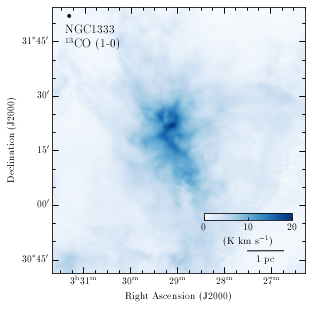

In [4]:
text_color = 'black'

hdu = fits.open(file_list_TdV[0])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=20.0, cmap=cmap, origin='lower')
ax.invert_xaxis()
ax.invert_yaxis()

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='FCRAO')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
# cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'$^{13}$CO (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_13CO_TdV.pdf', dpi=200)

Set OBSGEO-B to    19.825833 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


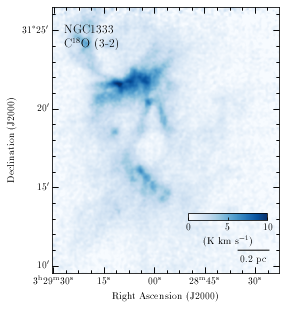

In [5]:
text_color = 'black'

hdu = fits.open(file_list_TdV[1])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, vmax=10, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='JCMT')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(K km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 5, 10])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'C$^{18}$O (3-2)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_C18O_TdV.pdf', dpi=200)

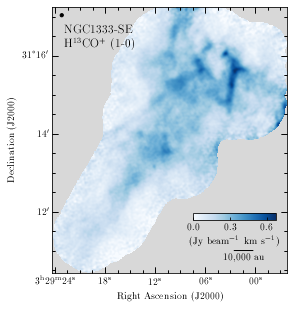

In [40]:
text_color = 'black'

hdu = fits.open(file_list_TdV[2])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0.0, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 0.3, 0.6])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'H$^{13}$CO$^+$ (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_H13COp_TdV.pdf', dpi=200)

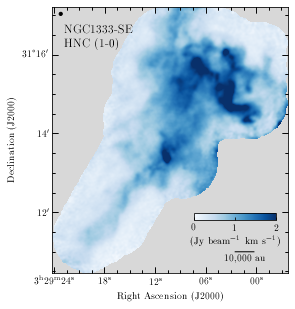

In [41]:
text_color = 'black'

hdu = fits.open(file_list_TdV[3])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=2, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
# cbar.set_ticks([0, 0.1, 0.2, 0.3])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HNC (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_HNC_TdV.pdf', dpi=200)

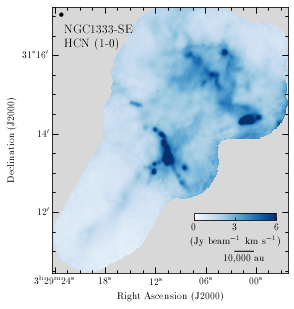

In [42]:
text_color = 'black'

hdu = fits.open(file_list_TdV[4])[0]
wcs = WCS(hdu.header)

cmap = plt.get_cmap(name='Blues').copy()
cmap.set_bad(color='0.85')

fig = plt.figure(figsize=my_figsize)
ax = plt.subplot(projection=wcs)
im = ax.imshow(hdu.data, vmin=0, vmax=6.0, cmap=cmap, origin='lower')

plot_setup_ngc1333_wcsaxes(ax, hdu, label_col=text_color, telescope='NOEMA')

cax = ax.inset_axes(col_pos)
cbar = plt.colorbar(im, cax=cax, label=r'(Jy beam$^{-1}$ km s$^{-1}$)', orientation='horizontal')
cbar.set_ticks([0, 3, 6])

fig.text(xpos_lab1, ypos_lab1, 'NGC1333-SE', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
fig.text(xpos_lab2, ypos_lab2, r'HCN (1-0)', transform=ax.transAxes, 
                horizontalalignment='left', color=text_color, size=12)
plt.tight_layout()
fig.savefig('figs/NGC1333_HCN_TdV.pdf', dpi=200)

## VCS Analysis
Define function that make all the heave lifting

In [7]:
from turbustat.statistics import VCS
file_h13cop = 'data/NGC1333_H13COp_L17-merged_fix_pad.fits'
file_hcn = 'data/NGC1333_HCN_L21-merged_fix_pad.fits'
file_hnc = 'data/NGC1333_HNC_L23-merged_fix_pad.fits'
file_c18o = 'data/ngc1333_c18o_3-2.fits'
file_13co = 'data/NGC1333_13CO_1-0.fits'

rms_hnc = 0.016 # Jy/beam
rms_hcn = 0.019 # Jy/beam
rms_h13cop = 0.018 # Jy/beam
rms_c18o = 0.21 # K
rms_13co = 0.123 # K

col_pal = ['#e41a1c', '#377eb8', '#4daf4a', 
           '#984ea3', '#ff7f00', '#ffff33']

In [10]:
cube_h13cop = fits.open(file_h13cop)[0]
vcs_h13cop = VCS(cube_h13cop)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     796.7
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           1.22e-63
Time:                        15:01:54   Log-Likelihood:                 130.22
No. Observations:                  92   AIC:                            -252.4
Df Residuals:                      88   BIC:                            -242.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6787      0.019    192.538      0.0

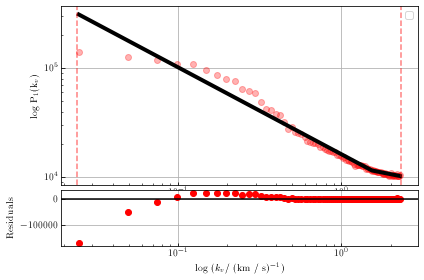

In [11]:
vcs_h13cop.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance) # high_cut=0.3 / u.pix,

In [12]:
cube_hcn = fits.open(file_hcn)[0]
vcs_hcn = VCS(cube_hcn)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     808.0
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          1.79e-122
Time:                        15:02:14   Log-Likelihood:                 100.05
No. Observations:                 236   AIC:                            -192.1
Df Residuals:                     232   BIC:                            -178.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9007      0.032    121.790      0.0

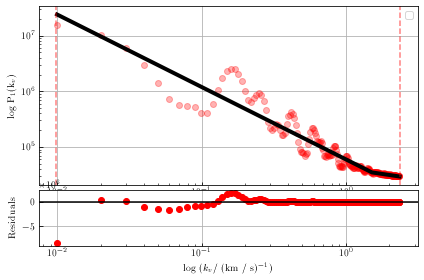

In [13]:
vcs_hcn.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance) # high_cut=0.3 / u.pix,

In [14]:
cube_hnc = fits.open(file_hnc)[0]
vcs_hnc = VCS(cube_hnc)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     767.4
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           2.65e-76
Time:                        15:02:20   Log-Likelihood:                 56.511
No. Observations:                 120   AIC:                            -105.0
Df Residuals:                     116   BIC:                            -93.87
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3426      0.039     85.730      0.0

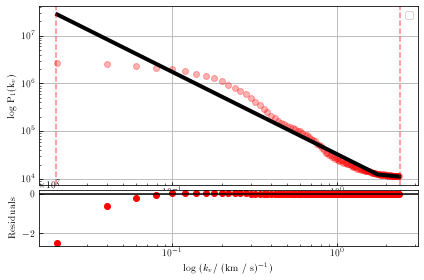

In [15]:
vcs_hnc.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance)

In [16]:
cube_c18o = fits.open(file_c18o)[0]
vcs_c18o = VCS(cube_c18o)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3726.
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          2.52e-124
Time:                        15:02:23   Log-Likelihood:                 223.90
No. Observations:                 132   AIC:                            -439.8
Df Residuals:                     128   BIC:                            -428.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6400      0.016    353.149      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


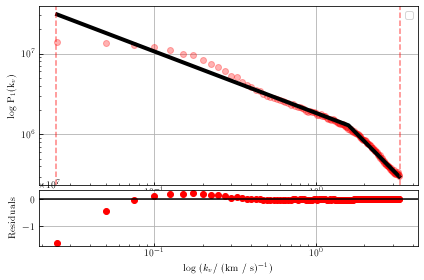

In [17]:
vcs_c18o.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance)

In [18]:
cube_13co = fits.open(file_13co)[0]
vcs_13co = VCS(cube_13co)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     5227.
Date:                Fri, 22 Jul 2022   Prob (F-statistic):          5.93e-256
Time:                        15:02:27   Log-Likelihood:                 412.84
No. Observations:                 300   AIC:                            -817.7
Df Residuals:                     296   BIC:                            -802.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6722      0.030    122.305      0.0

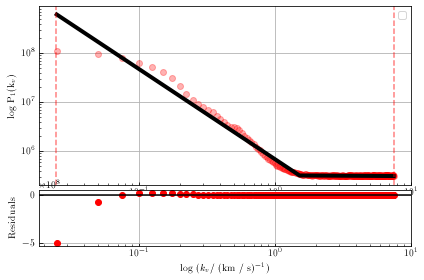

In [19]:
vcs_13co.run(verbose=True, xunit=(u.km / u.s)**-1, distance=distance)

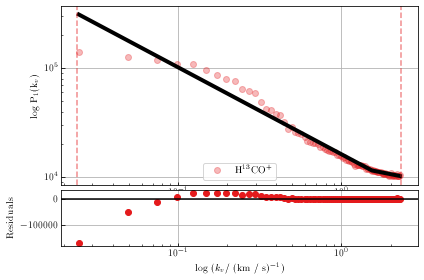

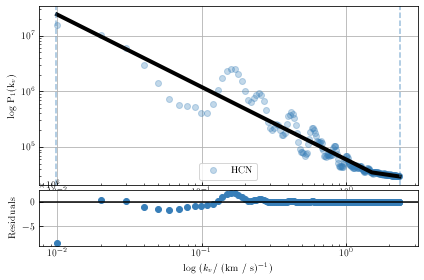

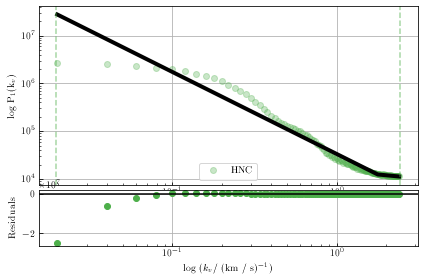

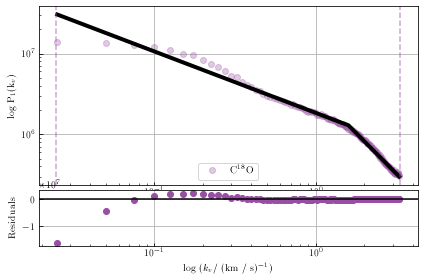

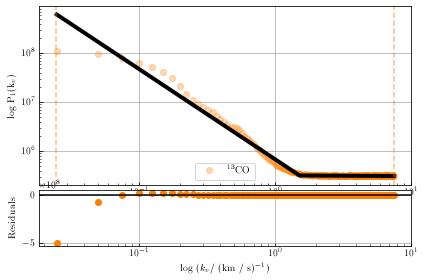

<Figure size 432x288 with 0 Axes>

In [20]:
# import seaborn as sb  
# col_pal = ['red', 'blue', 'orange']#sb.color_palette()  
vcs_h13cop.plot_fit(color=col_pal[0], label=r'H$^{13}$CO$^{+}$', xunit=(u.km / u.s)**-1)
vcs_hcn.plot_fit(color=col_pal[1], label=r'HCN', xunit=(u.km / u.s)**-1)
vcs_hnc.plot_fit(color=col_pal[2], label=r'HNC', xunit=(u.km / u.s)**-1)
vcs_c18o.plot_fit(color=col_pal[3], label=r'C$^{18}$O', xunit=(u.km / u.s)**-1)
vcs_13co.plot_fit(color=col_pal[4], label=r'$^{13}$CO', xunit=(u.km / u.s)**-1)
# plt.legend(frameon=True, loc='lower left')
# plt.xlim([0.1, 2.5])
# plt.ylim([2, 9.5])  
plt.tight_layout()  

Now a plot of all data cubes used in the analysis.

/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jpineda/opt/anaconda3/envs/py3/lib/python3.9/site-packages/astropy/units/quantity.py:

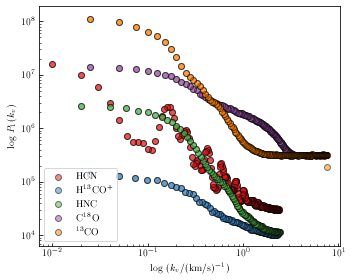

In [21]:
fig, ax = plt.subplots(figsize = (5, 4))
# conv_NH3
ax.scatter(vcs_hcn._spectral_freq_unit_conversion(vcs_hcn.freqs, (u.km / u.s)**-1), 
           vcs_hcn.ps1D, 
           color=col_pal[0], label=r'HCN', alpha=0.5, edgecolors="k")

ax.scatter(vcs_h13cop._spectral_freq_unit_conversion(vcs_h13cop.freqs, (u.km / u.s)**-1),
           vcs_h13cop.ps1D, 
           color=col_pal[1], label=r'H$^{13}$CO$^{+}$', alpha=0.5, edgecolors="k")

ax.scatter(vcs_hnc._spectral_freq_unit_conversion(vcs_hnc.freqs, (u.km / u.s)**-1),
           vcs_hnc.ps1D, 
           color=col_pal[2], label=r'HNC', alpha=0.5, edgecolors="k")

ax.scatter(vcs_c18o._spectral_freq_unit_conversion(vcs_c18o.freqs, (u.km / u.s)**-1),
           vcs_c18o.ps1D, 
           color=col_pal[3], label=r'C$^{18}$O', alpha=0.5, edgecolors="k")

ax.scatter(vcs_13co._spectral_freq_unit_conversion(vcs_13co.freqs, (u.km / u.s)**-1),
           vcs_13co.ps1D, 
           color=col_pal[4], label=r'$^{13}$CO', alpha=0.5, edgecolors="k")

plt.legend(frameon=True, loc='lower left')
ax.set_xlabel(r'log ($k_v$/(km/s)$^{-1}$)')
ax.set_ylabel('log $P_1(k_v)$')
ax.set_xscale("log")
ax.set_yscale("log")

plt.tight_layout()
fig.savefig('figs/NGC1333_VCS_lines.pdf')

## Now try PCA
Maybe this will work better

In [4]:
from turbustat.statistics import PCA

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [9]:
pca_hcn = PCA(cube_hcn, distance=distance)

Proportion of Variance kept: 0.8459332972705425
Index: 0.11 (-0.02, 0.24)
Gamma: -0.02 (-0.42, 0.43)
Sonic length: 1.521e+64 (1.899e+67, -1.896e+67) pix at 10.0 K


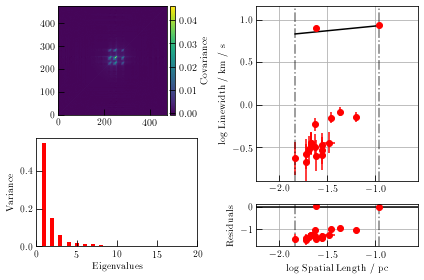

In [10]:
pca_hcn.run(verbose=True, min_eigval=3.5*rms_hcn**2, spatial_output_unit=u.pc,
        spectral_output_unit=u.km / u.s, mean_sub=True, brunt_beamcorrect=True)

In [15]:
pca_hnc = PCA(cube_hnc, distance=distance)

Proportion of Variance kept: 0.9122437038529118
Index: 0.06 (-0.09, 0.22)
Gamma: -0.09 (-0.52, 0.39)
Sonic length: 1.040e+07 (3.446e+08, -3.239e+08) pix at 10.0 K


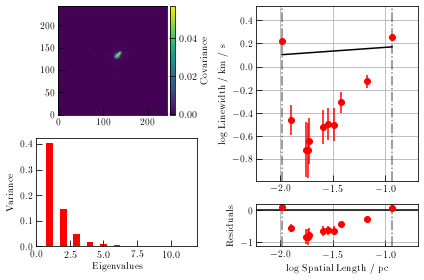

In [18]:
pca_hnc.run(verbose=True, min_eigval=3*rms_hnc**2, spatial_output_unit=u.pc, # n_eigs=10, 
        spectral_output_unit=u.km / u.s, mean_sub=True, brunt_beamcorrect=False)

In [27]:
pca_h13cop = PCA(cube_h13cop, distance=distance)

Proportion of Variance kept: 0.19155211099225275
Index: 0.62 (0.59, 0.64)
Gamma: 0.75 (0.41, 1.09)
Sonic length: 9.197e+00 (4.430e+00, 1.396e+01) pix at 10.0 K


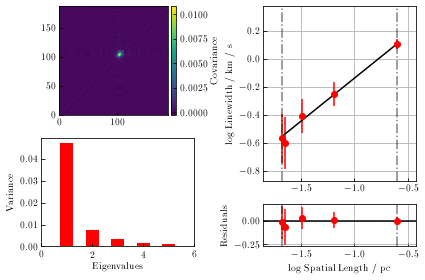

In [28]:
pca_h13cop.run(verbose=True, min_eigval=3*rms_h13cop**2, spatial_output_unit=u.pc,  #n_eigs=10,
        spectral_output_unit=u.km / u.s, brunt_beamcorrect=True)#,
#               beam_fwhm=cube_h13cop.header['BMAJ']*u.deg)

In [29]:
pca_c18o = PCA(cube_c18o, distance=distance)

Proportion of Variance kept: 0.17146024804141086
Index: 0.43 (0.38, 0.49)
Gamma: 0.47 (0.12, 0.84)
Sonic length: 5.501e+00 (2.256e+00, 8.746e+00) pix at 10.0 K


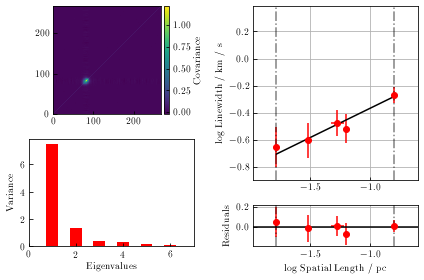

In [30]:
pca_c18o.run(verbose=True, min_eigval=3*rms_c18o**2, spatial_output_unit=u.pc,  #n_eigs=10,
        spectral_output_unit=u.km / u.s, brunt_beamcorrect=True, beam_fwhm=14*u.arcsec)

In [31]:
pca_13co = PCA(cube_13co, distance=distance)

Proportion of Variance kept: 0.6550338592290976
Index: 0.50 (0.43, 0.58)
Gamma: 0.58 (0.18, 1.00)
Sonic length: 2.069e+00 (1.613e+00, 2.526e+00) pix at 10.0 K


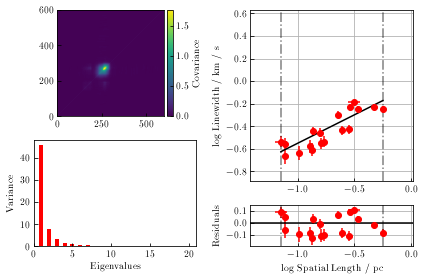

In [32]:
pca_13co.run(verbose=True, min_eigval=3*rms_13co**2, spatial_output_unit=u.pc,  #n_eigs=10,
        spectral_output_unit=u.km / u.s, brunt_beamcorrect=True)#, beam_fwhm=14*u.arcsec)

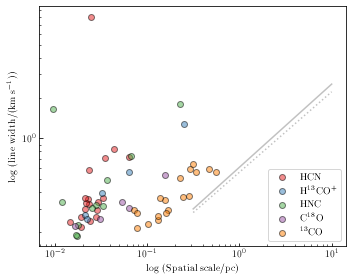

In [33]:
fig, ax = plt.subplots(figsize = (5, 4))

x_sample = np.logspace(-0.5, 1, num=10)
# conv_NH3
ax.scatter(pca_hcn.spatial_width(u.pc), 
           pca_hcn.spectral_width(u.km / u.s), 
           color=col_pal[0], label=r'HCN', alpha=0.5, edgecolors="k")

ax.scatter(pca_h13cop.spatial_width(u.pc),
           pca_h13cop.spectral_width(u.km / u.s),
           color=col_pal[1], label=r'H$^{13}$CO$^{+}$', alpha=0.5, edgecolors="k")

ax.scatter(pca_hnc.spatial_width(u.pc),
           pca_hnc.spectral_width(u.km / u.s), 
           color=col_pal[2], label=r'HNC', alpha=0.5, edgecolors="k")

ax.scatter(pca_c18o.spatial_width(u.pc),
           pca_c18o.spectral_width(u.km / u.s), 
           color=col_pal[3], label=r'C$^{18}$O', alpha=0.5, edgecolors="k")

ax.scatter(pca_13co.spatial_width(u.pc),
           pca_13co.spectral_width(u.km / u.s), 
           color=col_pal[4], label=r'$^{13}$CO', alpha=0.5, edgecolors="k")


# ax.set_ylim([0.1, 1e5])
# ax.set_xlim([3, 200])
# PCA values taken from Figure 11 in Roman-Duval et al. (2011)
# https://ui.adsabs.harvard.edu/abs/2011ApJ...740..120R/abstract
alpha_PCA = 0.62
c_PCA = 0.61
alpha_PCA_med = 0.60
c_PCA_med = 0.56
ax.plot(x_sample, c_PCA * x_sample**alpha_PCA, color='0.4', alpha=0.4)
ax.plot(x_sample, c_PCA_med * x_sample**alpha_PCA_med, color='0.4', alpha=0.4, ls=':')

plt.legend(frameon=True, loc='lower right')
ax.set_xlabel(r'log (Spatial scale/pc)')
ax.set_ylabel(r'log (line width/(km s$^{-1}$))')
ax.set_xscale("log")
ax.set_yscale("log")

plt.tight_layout()
fig.savefig('figs/NGC1333_PCA_lines.pdf')

In [34]:
# import pickle

In [35]:
# with open('data/NGC1333_PCA_HCN.pickle', 'wb') as handle:
#     pickle.dump(pca_hcn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
# with open('data/NGC1333_PCA_HNC.pickle', 'wb') as handle:
#     pickle.dump(pca_hnc, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# with open('data/NGC1333_PCA_H13COp.pickle', 'wb') as handle:
#     pickle.dump(pca_h13cop, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
# with open('data/NGC1333_PCA_C18O.pickle', 'wb') as handle:
#     pickle.dump(pca_c18o, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
# with open('data/NGC1333_PCA_13CO.pickle', 'wb') as handle:
#     pickle.dump(pca_13co, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('data/NGC1333_PCA_13CO.pickle', 'rb') as handle:
#     pca_13co = pickle.load(handle)

### Velocity Power Spectrum
Now we calculate the power spectrum for the different lines, already padded to the mean velocity.

In [21]:
from turbustat.statistics import PowerSpectrum

In [19]:
vc_13co = fits.open('data/NGC1333_13CO_1-0-Mom1.fits')[0]
vc_c18o = fits.open('data/NGC1333_SE_C18O-Mom1_QA_pad.fits')[0]
vc_h13cop = fits.open('data/NGC1333_H13COp_L17-Mom1_QA_pad.fits')[0]
vc_hnc = fits.open('data/NGC1333_HNC_L23-Mom1_QA_pad.fits')[0]
vc_hcn = fits.open('data/NGC1333_HCN_L21-Mom1_QA_pad.fits')[0]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.698
Date:                Mon, 25 Jul 2022   Prob (F-statistic):              0.195
Time:                        16:55:37   Log-Likelihood:                -129.81
No. Observations:                 131   AIC:                             263.6
Df Residuals:                     129   BIC:                             269.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9830      0.170     29.354      0.0

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


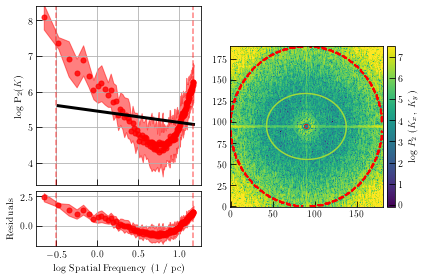

In [100]:
pspec_13co = PowerSpectrum(vc_13co, distance=distance)
pspec_13co.run(verbose=True, xunit=u.pc**-1, beam_correct=True) #high_cut=1/(50*u.arcsec))

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/base_pspec2.py:442: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     84.47
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           3.03e-17
Time:                        16:55:54   Log-Likelihood:                -557.65
No. Observations:                 222   AIC:                             1119.
Df Residuals:                     220   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.9370      0.636     23.470      0.0

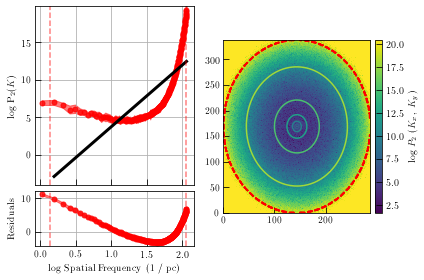

In [101]:
pspec_c18o = PowerSpectrum(vc_c18o, distance=distance)
pspec_c18o.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(16*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     130.3
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           1.02e-25
Time:                        16:56:02   Log-Likelihood:                -1041.5
No. Observations:                 337   AIC:                             2087.
Df Residuals:                     335   BIC:                             2095.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.0972      0.910     25.379      0.0

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


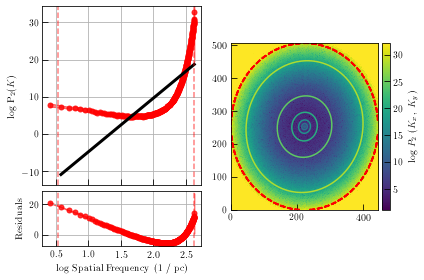

In [102]:
pspec_h13cop = PowerSpectrum(vc_h13cop, distance=distance)
pspec_h13cop.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(5*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 5.017e+04
Date:                Mon, 25 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:47:09   Log-Likelihood:                 314.91
No. Observations:                 349   AIC:                            -625.8
Df Residuals:                     347   BIC:                            -618.1
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6436      0.011     61.240      0.0

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


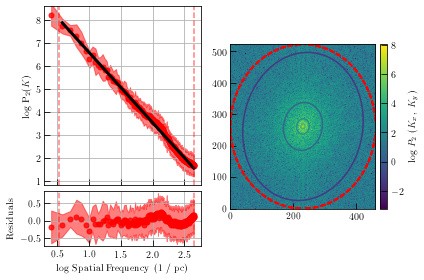

In [24]:
pspec_hnc = PowerSpectrum(vc_hnc, distance=distance)
pspec_hnc.run(verbose=True, xunit=u.pc**-1)#, high_cut=1/(5*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     128.4
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           1.78e-25
Time:                        16:56:09   Log-Likelihood:                -1079.6
No. Observations:                 343   AIC:                             2163.
Df Residuals:                     341   BIC:                             2171.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.2260      0.944     25.676      0.0

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


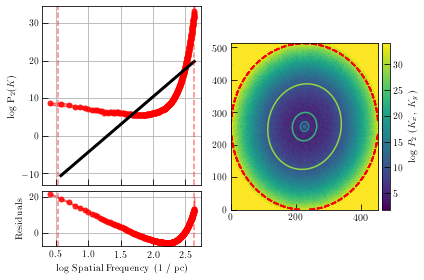

In [103]:
pspec_hcn = PowerSpectrum(vc_hcn, distance=distance)
pspec_hcn.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(5*u.arcsec))

In [31]:
conv_13co = np.abs((pspec_13co.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_c18o = np.abs((pspec_c18o.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_h13cop = np.abs((pspec_h13cop.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_hnc = np.abs((pspec_hnc.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)
conv_hcn = np.abs((pspec_hcn.header['CDELT1'] * u.deg.to('', equivalencies=u.dimensionless_angles()))*distance).to(u.pc)

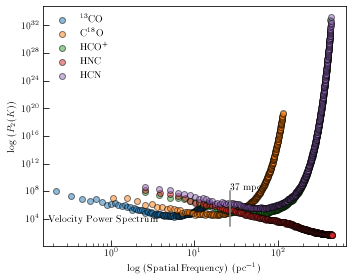

In [104]:
fig, ax = plt.subplots(figsize=(5, 4))
y_min = 0.1
y_max = 1e6

ax.scatter(pspec_13co.freqs / conv_13co, pspec_13co.ps1D, alpha=0.5, edgecolors='k', label=r'$^{13}$CO')
ax.scatter(pspec_c18o.freqs / conv_c18o, pspec_c18o.ps1D, alpha=0.5, edgecolors='k', label=r'C$^{18}$O')
ax.scatter(pspec_h13cop.freqs / conv_h13cop, pspec_h13cop.ps1D, alpha=0.5, edgecolors='k', label=r'HCO$^{+}$')
ax.scatter(pspec_hnc.freqs / conv_hnc, pspec_hnc.ps1D, alpha=0.5, edgecolors='k', label=r'HNC')
ax.scatter(pspec_hcn.freqs / conv_hcn, pspec_hcn.ps1D, alpha=0.5, edgecolors='k', label=r'HCN')

ax.plot([1./37e-3, 1./37e-3], [1e3, 1e8], color='gray')
ax.text(1./37e-3, 2e8, '37 mpc')

plt.legend(frameon=False)
ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
ax.set_ylabel(r'log ($P_2(K)$)')
ax.set_xscale('log')
ax.set_yscale('log')

ax.text(0.8, 5e3, 'Velocity Power Spectrum', horizontalalignment='center')
plt.tight_layout()
fig.savefig('figs/NGC1333_Velocity_Power_Spectrum.pdf')

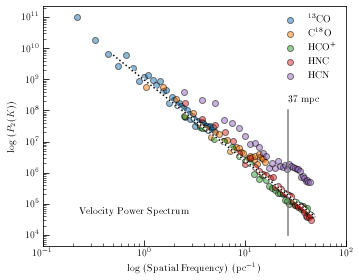

In [105]:
fig, ax = plt.subplots(figsize=(5, 4))
y_min = 0.1
y_max = 1e6

f_13co = 800
f_c18o = 60

ax.scatter(pspec_13co.freqs[gd_13co] / conv_13co, f_13co * pspec_13co.ps1D[gd_13co], alpha=0.5, edgecolors='k', label=r'$^{13}$CO')
ax.scatter(pspec_c18o.freqs[gd_c18o] / conv_c18o, f_c18o * pspec_c18o.ps1D[gd_c18o], alpha=0.5, edgecolors='k', label=r'C$^{18}$O')
ax.scatter(pspec_h13cop.freqs[gd_h13cop] / conv_h13cop, pspec_h13cop.ps1D[gd_h13cop], alpha=0.5, edgecolors='k', label=r'HCO$^{+}$')
ax.scatter(pspec_hnc.freqs[gd_hnc] / conv_hnc, pspec_hnc.ps1D[gd_hnc], alpha=0.5, edgecolors='k', label=r'HNC')
ax.scatter(pspec_hcn.freqs[gd_hcn] / conv_hcn, pspec_hcn.ps1D[gd_hcn], alpha=0.5, edgecolors='k', label=r'HCN')

ax.plot([1./37e-3, 1./37e-3], [1e4, 1e8], color='gray')
ax.text(1./37e-3, 2e8, '37 mpc')

x_sample = np.array([0.5, 50])
ax.plot(x_sample, 1e9 / x_sample**(2.6), color='w', lw=2)
ax.plot(x_sample, 1e9 / x_sample**(2.6), color='k', ls=':')

plt.legend(frameon=False)
ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
ax.set_ylabel(r'log ($P_2(K)$)')
ax.set_xscale('log')
ax.set_yscale('log')

ax.text(0.8, 5e4, 'Velocity Power Spectrum', horizontalalignment='center')
plt.tight_layout()

ax.set_xlim(0.1, 100)
fig.savefig('figs/NGC1333_Velocity_Power_Spectrum_arb.pdf')

### Power Spectrum of Intensity

In [42]:
TdV_13co = fits.open('data/NGC1333_13CO_1-0-TdV.fits')[0]
TdV_c18o = fits.open('data/NGC1333_SE_C18O-TdV.fits')[0]
TdV_h13cop = fits.open('data/NGC1333_H13COp_L17-TdV_pad.fits')[0]
TdV_hnc = fits.open('data/NGC1333_HNC_L23-TdV_pad.fits')[0]
TdV_hcn = fits.open('data/NGC1333_HCN_L21-TdV_pad.fits')[0]

TdV_hnc_nopad = fits.open('data/NGC1333_HNC_L23-TdV.fits')[0]
TdV_hcn_nopad = fits.open('data/NGC1333_HCN_L21-TdV.fits')[0]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     20.09
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           1.61e-05
Time:                        15:55:13   Log-Likelihood:                -114.63
No. Observations:                 131   AIC:                             233.3
Df Residuals:                     129   BIC:                             239.0
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2210      0.157     26.851      0.0

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


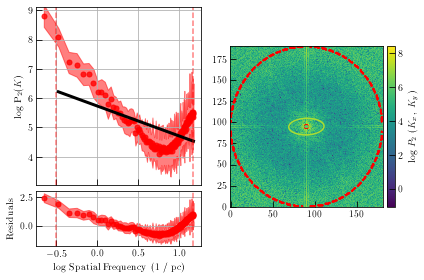

In [64]:
pspec_13co_TdV = PowerSpectrum(TdV_13co, distance=distance)
pspec_13co_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(50*u.arcsec))

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/base_pspec2.py:442: UserWarning: The elliptical parameter is close to 1. The field may be isotropic and the fit is not converging to 1. Consider fitting with `fix_ellip_params=True`, which forces the ellipticity to 1.
  warnings.warn("The elliptical parameter is close to 1. The field "
/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     66.80
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           2.36e-14
Time:                        15:55:33   Log-Likelihood:                -541.30
No. Observations:                 222   AIC:                             1087.
Df Residuals:                     220   BIC:                             1093.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0126      0.586     23.903      0.0

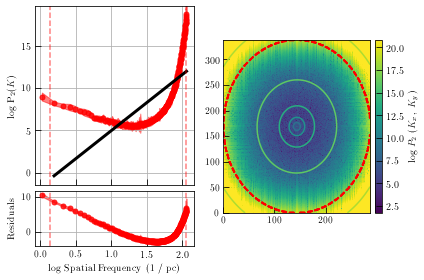

In [66]:
pspec_c18o_TdV = PowerSpectrum(TdV_c18o, distance=distance)
pspec_c18o_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(16*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     129.2
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           1.53e-25
Time:                        15:55:48   Log-Likelihood:                -1054.4
No. Observations:                 337   AIC:                             2113.
Df Residuals:                     335   BIC:                             2120.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.6303      0.935     24.204      0.0

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


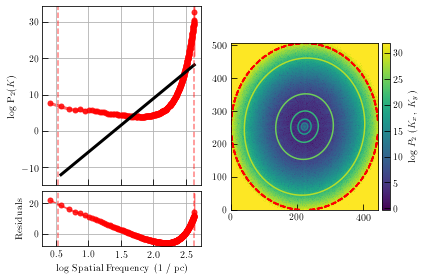

In [67]:
pspec_h13cop_TdV = PowerSpectrum(TdV_h13cop, distance=distance)
pspec_h13cop_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(16*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     128.7
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           1.40e-25
Time:                        15:55:55   Log-Likelihood:                -1108.3
No. Observations:                 349   AIC:                             2221.
Df Residuals:                     347   BIC:                             2228.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1240      0.960     25.137      0.0

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


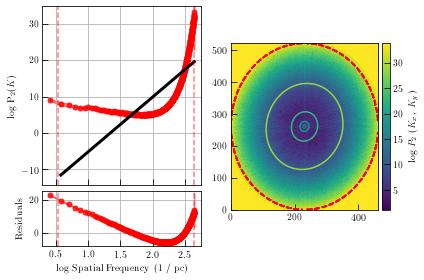

In [68]:
pspec_hnc_TdV = PowerSpectrum(TdV_hnc, distance=distance)
pspec_hnc_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=True)#, high_cut=1/(16*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     128.7
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           1.57e-25
Time:                        15:56:12   Log-Likelihood:                -1088.2
No. Observations:                 343   AIC:                             2180.
Df Residuals:                     341   BIC:                             2188.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2174      0.962     26.204      0.0

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


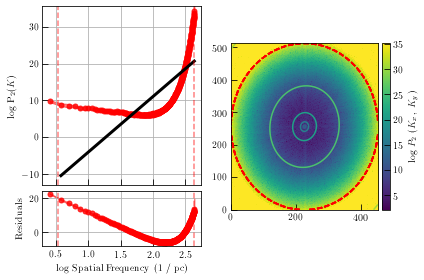

In [69]:
pspec_hcn_TdV = PowerSpectrum(TdV_hcn, distance=distance)
pspec_hcn_TdV.run(verbose=True, xunit=u.pc**-1, beam_correct=True)# , high_cut=1/(6*u.arcsec))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.466e+04
Date:                Mon, 25 Jul 2022   Prob (F-statistic):          2.92e-282
Time:                        15:30:09   Log-Likelihood:                 196.57
No. Observations:                 343   AIC:                            -389.1
Df Residuals:                     341   BIC:                            -381.5
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9502      0.017    111.944      0.0

/Users/jpineda/miniconda3/envs/py3/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


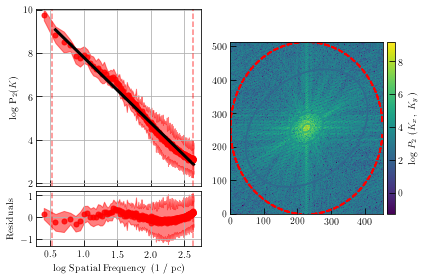

In [43]:
pspec_hcn_TdV_nopad = PowerSpectrum(TdV_hcn_nopad, distance=distance)
pspec_hcn_TdV_nopad.run(verbose=True, xunit=u.pc**-1, high_cut=1/(6*u.arcsec))

In [73]:
gd_13co = (pspec_13co_TdV.freqs.value < 0.33 * np.abs(pspec_13co_TdV.header['CDELT1']) / pspec_13co_TdV.header['BMAJ'])
gd_c18o = (pspec_c18o_TdV.freqs.value < 0.33 * np.abs(pspec_c18o_TdV.header['CDELT1']) / pspec_c18o_TdV.header['BMAJ'])

gd_h13cop = (pspec_h13cop_TdV.freqs.value < 0.33 * np.abs(pspec_h13cop_TdV.header['CDELT1']) / pspec_h13cop_TdV.header['BMAJ'])
gd_hcn = (pspec_hcn_TdV.freqs.value < 0.33 * np.abs(pspec_hcn_TdV.header['CDELT1']) / pspec_hcn_TdV.header['BMAJ'])
gd_hnc = (pspec_hnc_TdV.freqs.value < 0.33 * np.abs(pspec_hnc_TdV.header['CDELT1']) / pspec_hnc_TdV.header['BMAJ'])


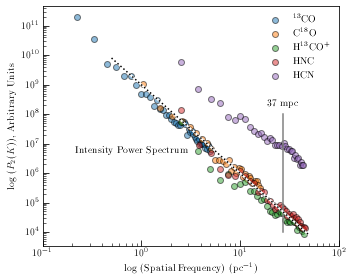

In [137]:
fig, ax = plt.subplots(figsize=(5, 4))
y_min = 0.1
y_max = 1e6

f_13co = 300
f_hnc = 0.1
# ax.scatter(pspec_13co_TdV.freqs / conv_13co, pspec_13co_TdV.ps1D, alpha=0.5, edgecolors='k', label=r'$^{13}$CO', marker='x')
ax.scatter(pspec_13co_TdV.freqs[gd_13co] / conv_13co, f_13co * pspec_13co_TdV.ps1D[gd_13co], alpha=0.5, edgecolors='k', label=r'$^{13}$CO')
ax.scatter(pspec_c18o_TdV.freqs[gd_c18o] / conv_c18o, pspec_c18o_TdV.ps1D[gd_c18o], alpha=0.5, edgecolors='k', label=r'C$^{18}$O')
ax.scatter(pspec_h13cop_TdV.freqs[gd_h13cop] / conv_h13cop, pspec_h13cop_TdV.ps1D[gd_h13cop], alpha=0.5, edgecolors='k', label=r'H$^{13}$CO$^{+}$')
ax.scatter(pspec_hnc_TdV.freqs[gd_hnc] / conv_hnc, f_hnc * pspec_hnc_TdV.ps1D[gd_hnc], alpha=0.5, edgecolors='k', label=r'HNC')
ax.scatter(pspec_hcn_TdV.freqs[gd_hcn] / conv_hcn, pspec_hcn_TdV.ps1D[gd_hcn], alpha=0.5, edgecolors='k', label=r'HCN')

# ax.scatter(pspec_hcn_TdV_nopad.freqs / conv_hcn, pspec_hcn_TdV_nopad.ps1D, alpha=0.5, edgecolors='k', label=r'HCN_nopad')

ax.plot([1./37e-3, 1./37e-3], [1e4, 1e8], color='gray')
ax.text(1./37e-3, 2e8, '37 mpc', horizontalalignment='center')

plt.legend(frameon=False)
ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
ax.set_ylabel(r'log ($P_2(K)$), Arbitrary Units')
ax.set_xscale('log')
ax.set_yscale('log')

x_sample = np.array([0.5, 50])
ax.plot(x_sample, 1e9 / x_sample**3, color='w', lw=2)
ax.plot(x_sample, 1e9 / x_sample**3, color='k', ls=':')

ax.text(0.8, 5e6, 'Intensity Power Spectrum', horizontalalignment='center')
ax.set_xlim(0.1, 100)
plt.tight_layout()
fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb.pdf')

In [ ]:
ps1D_stddev

The goal is to combine the power-spectrum from the different tracers using scaling parameters for $^{13}$CO and  C$^{18}$O, $f_{13}$ and $f_{18}$. The model can be written as:
\begin{equation}
P(k) = A k^{\beta}~,
\end{equation}
where the data for HCO$^+$ is used as anchor.

In [157]:
freq_13co = (pspec_13co_TdV.freqs[gd_13co] / conv_13co).value
P_TdV_13co = pspec_13co_TdV.ps1D[gd_13co] * 1e-7
eP_TdV_13co = pspec_13co_TdV.ps1D_stddev[gd_13co] * 1e-7

freq_c18o = (pspec_c18o_TdV.freqs[gd_c18o] / conv_c18o).value
P_TdV_c18o = pspec_c18o_TdV.ps1D[gd_c18o] * 1e-7
eP_TdV_c18o = pspec_c18o_TdV.ps1D_stddev[gd_c18o] * 1e-7

freq_h13cop = (pspec_h13cop_TdV.freqs[gd_h13cop] / conv_h13cop).value
P_TdV_h13cop = pspec_h13cop_TdV.ps1D[gd_h13cop] * 1e-7
eP_TdV_h13cop = pspec_h13cop_TdV.ps1D_stddev[gd_h13cop] * 1e-7

freq_hnc = (pspec_hnc_TdV.freqs[gd_hnc] / conv_hnc).value
P_TdV_hnc = pspec_hnc_TdV.ps1D[gd_hnc] * 1e-7
eP_TdV_hnc = pspec_hnc_TdV.ps1D_stddev[gd_hnc] * 1e-7

freq_all_hnc = np.append(freq_13co, np.append(freq_c18o, freq_hnc))
freq_all_h13cop = np.append(freq_13co, np.append(freq_c18o, freq_h13cop))

def log_prior_TdV_HNC(theta):
    A, beta, f_13, f_hnc = theta
    if 1e1 < A < 1e3 and -4.0 < beta < -2.0 and 3e1 < f_13 < 3e3 and 1e-3 < f_hnc < 100.0:
        return 0.0
    return -np.inf

def log_likelihood_TdV_HNC(theta): #, x, y, yerr):
    A, beta, f_13, f_hnc = theta
#     model_13 = A * np.power(freq_13co, beta)
#     model_18 = A * np.power(freq_c18o, beta)
#     model_hnc = A * np.power(freq_hnc, beta)
    model_all_hnc = A * np.power(freq_all_hnc, beta)
    P_TdV_all_hnc = np.append(f_13 * P_TdV_13co, np.append(P_TdV_c18o, f_hnc * P_TdV_hnc))
    sigma_all_hnc = np.append(f_13 * eP_TdV_13co, np.append(eP_TdV_c18o, f_hnc * eP_TdV_hnc))
#     sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((P_TdV_all_hnc - model_all_hnc)**2 / sigma_all_hnc**2)
# (np.sum((f_13 * P_TdV_13co - model_13) ** 2 / (f_13 * eP_TdV_13co)**2) + 
#                    np.sum((P_TdV_c18o - model_18) ** 2 / (eP_TdV_c18o)**2) + 
#                    np.sum((f_hnc * P_TdV_hnc - model_hnc) ** 2 / (f_hnc * eP_TdV_hnc)**2))

def log_probability_TdV_HNC(theta):
    lp = log_prior_TdV_HNC(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_TdV_HNC(theta)


def log_prior_TdV_H13COp(theta):
    A, beta, f_13, f_h13cop = theta
    if 1e1 < A < 1e3 and -4.0 < beta < -2.0 and 3e1 < f_13 < 3e3 and 1e-3 < f_h13cop < 100.0:
        return 0.0
    return -np.inf

def log_likelihood_TdV_H13COp(theta): #, x, y, yerr):
    A, beta, f_13, f_h13cop = theta
    model_all_h13cop = A * np.power(freq_all_h13cop, beta)
    P_TdV_all_h13cop = np.append(f_13 * P_TdV_13co, np.append(P_TdV_c18o, f_h13cop * P_TdV_h13cop))
    sigma_all_h13cop = np.append(f_13 * eP_TdV_13co, np.append(eP_TdV_c18o, f_h13cop * eP_TdV_h13cop))
    return -0.5 * np.sum((P_TdV_all_h13cop - model_all_h13cop)**2 / sigma_all_h13cop**2)

def log_probability_TdV_H13COp(theta):
    lp = log_prior_TdV_H13COp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_TdV_H13COp(theta)

In [156]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood_TdV_HNC(*args)
initial = np.array([1e2, -3.0, 300., 0.1])
soln_hnc = minimize(nll, initial)
print(soln_hnc.x)


[ 4.78516248e+01 -2.68528711e+00  2.87850026e+02  1.58382818e-01]


In [159]:
nll = lambda *args: -log_likelihood_TdV_H13COp(*args)
initial = np.array([1e2, -3.0, 300., 1])
soln_h13cop = minimize(nll, initial)
print(soln_h13cop.x)

[ 44.11019424  -2.64193084 277.08112699   3.06735585]


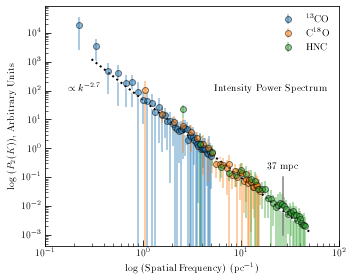

In [180]:
fig, ax = plt.subplots(figsize=(5, 4))
y_min = 0.1
y_max = 1e6

f_13co = soln_hnc.x[2]
f_hnc = soln_hnc.x[3]

label_power_fit = r'$\propto k^{'
label_power_fit = label_power_fit + '{0}'.format(np.round(soln_hnc.x[1], decimals=1)) + '}$'

ax.errorbar(freq_13co, f_13co * P_TdV_13co, yerr=f_13co * eP_TdV_13co, alpha=0.5, markeredgecolor='k', label=r'$^{13}$CO', fmt="o")
ax.errorbar(freq_c18o, P_TdV_c18o, yerr=eP_TdV_c18o, alpha=0.5, markeredgecolor='k', label=r'C$^{18}$O', fmt="o")
ax.errorbar(freq_hnc, f_hnc * P_TdV_hnc, yerr=f_hnc * eP_TdV_hnc, alpha=0.5, markeredgecolor='k', label=r'HNC', fmt="o")

ax.plot([1./37e-3, 1./37e-3], [1e-3, 0.1], color='gray')
ax.text(1./37e-3, 0.2, '37 mpc', horizontalalignment='center')

plt.legend(frameon=False)
ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
ax.set_ylabel(r'log ($P_2(K)$), Arbitrary Units')
ax.set_xscale('log')
ax.set_yscale('log')

x_sample = np.array([0.3, 50])
ax.plot(x_sample, soln_hnc.x[0] * np.power(x_sample, soln_hnc.x[1]), color='w', lw=3)
ax.plot(x_sample, soln_hnc.x[0] * np.power(x_sample, soln_hnc.x[1]), color='k', lw=2, ls=':')

ax.text(0.25, 1e2, label_power_fit, horizontalalignment='center')

ax.text(20, 1e2, 'Intensity Power Spectrum', horizontalalignment='center')
ax.set_xlim(0.1, 100)
plt.tight_layout()
fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_HNC.pdf')

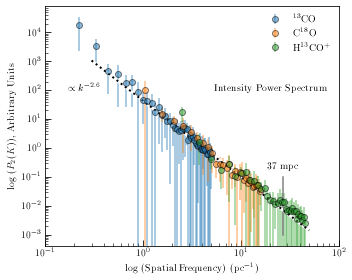

In [181]:
fig, ax = plt.subplots(figsize=(5, 4))
y_min = 0.1
y_max = 1e6

f_13co = soln_h13cop.x[2]
f_h13cop = soln_h13cop.x[3]
label_power_fit = r'$\propto k^{'
label_power_fit = label_power_fit + '{0}'.format(np.round(soln_h13cop.x[1], decimals=1)) + '}$'

ax.errorbar(freq_13co, f_13co * P_TdV_13co, yerr=f_13co * eP_TdV_13co, alpha=0.5, markeredgecolor='k', label=r'$^{13}$CO', fmt="o")
ax.errorbar(freq_c18o, P_TdV_c18o, yerr=eP_TdV_c18o, alpha=0.5, markeredgecolor='k', label=r'C$^{18}$O', fmt="o")
ax.errorbar(freq_h13cop, f_h13cop * P_TdV_h13cop, yerr=f_h13cop * eP_TdV_h13cop, alpha=0.5, markeredgecolor='k', label=r'H$^{13}$CO$^+$', fmt="o")

ax.plot([1./37e-3, 1./37e-3], [1e-3, 0.1], color='gray')
ax.text(1./37e-3, 0.2, '37 mpc', horizontalalignment='center')

plt.legend(frameon=False)
ax.set_xlabel(r'log (Spatial Frequency) (pc$^{{-1}}$)')
ax.set_ylabel(r'log ($P_2(K)$), Arbitrary Units')
ax.set_xscale('log')
ax.set_yscale('log')

x_sample = np.array([0.3, 50])
ax.plot(x_sample, soln_h13cop.x[0] * np.power(x_sample, soln_h13cop.x[1]), color='w', lw=3)
ax.plot(x_sample, soln_h13cop.x[0] * np.power(x_sample, soln_h13cop.x[1]), color='k', lw=2, ls=':')

ax.text(0.25, 1e2, label_power_fit, horizontalalignment='center')

ax.text(20, 1e2, 'Intensity Power Spectrum', horizontalalignment='center')
ax.set_xlim(0.1, 100)
plt.tight_layout()
fig.savefig('figs/NGC1333_Intensity_Power_Spectrum_Arb_fit_H13COp.pdf')

(0.001, 1)

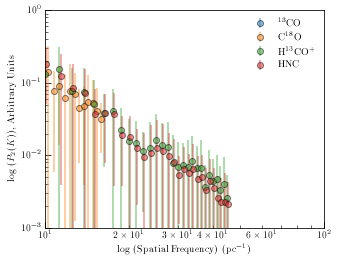

In [164]:
fig, ax = plt.subplots(figsize=(5, 4))

f_13co = soln_h13cop.x[2]
f_h13cop = soln_h13cop.x[3]
f_hnc = soln_hnc.x[3]

ax.errorbar(freq_13co, f_13co * P_TdV_13co, yerr=f_13co * eP_TdV_13co, 
            alpha=0.5, markeredgecolor='k', label=r'$^{13}$CO', fmt="o")
ax.errorbar(freq_c18o, P_TdV_c18o, yerr=eP_TdV_c18o, 
            alpha=0.5, markeredgecolor='k', label=r'C$^{18}$O', fmt="o")
ax.errorbar(freq_h13cop, f_h13cop * P_TdV_h13cop, yerr=f_h13cop * eP_TdV_h13cop, 
            alpha=0.5, markeredgecolor='k', label=r'H$^{13}$CO$^+$', fmt="o")
ax.errorbar(freq_hnc, f_hnc * P_TdV_hnc, yerr=f_hnc * eP_TdV_hnc, 
            alpha=0.5, markeredgecolor='k', label=r'HNC', fmt="o")

plt.legend(frameon=False)
ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
ax.set_ylabel(r'log ($P_2(K)$), Arbitrary Units')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(10, 100)
ax.set_ylim(1e-3, 1)

In [188]:
gd_vc_13co = (pspec_13co.freqs.value < 0.33 * np.abs(pspec_13co.header['CDELT1']) / pspec_13co.header['BMAJ'])
gd_vc_c18o = (pspec_c18o.freqs.value < 0.33 * np.abs(pspec_c18o.header['CDELT1']) / pspec_c18o.header['BMAJ'])

gd_vc_h13cop = (pspec_h13cop.freqs.value < 0.33 * np.abs(pspec_h13cop.header['CDELT1']) / pspec_h13cop.header['BMAJ'])
gd_vc_hcn = (pspec_hcn.freqs.value < 0.33 * np.abs(pspec_hcn.header['CDELT1']) / pspec_hcn.header['BMAJ'])
gd_vc_hnc = (pspec_hnc.freqs.value < 0.33 * np.abs(pspec_hnc.header['CDELT1']) / pspec_hnc.header['BMAJ'])

freq_vc_13co = (pspec_13co.freqs[gd_vc_13co] / conv_13co).value
P_vc_13co = pspec_13co.ps1D[gd_vc_13co] * 1e-6
eP_vc_13co = pspec_13co.ps1D_stddev[gd_vc_13co] * 1e-6

freq_vc_c18o = (pspec_c18o.freqs[gd_vc_c18o] / conv_c18o).value
P_vc_c18o = pspec_c18o.ps1D[gd_vc_c18o] * 1e-6
eP_vc_c18o = pspec_c18o.ps1D_stddev[gd_vc_c18o] * 1e-6

freq_vc_h13cop = (pspec_h13cop.freqs[gd_vc_h13cop] / conv_h13cop).value
P_vc_h13cop = pspec_h13cop.ps1D[gd_vc_h13cop] * 1e-6
eP_vc_h13cop = pspec_h13cop.ps1D_stddev[gd_vc_h13cop] * 1e-6

freq_vc_hnc = (pspec_hnc.freqs[gd_vc_hnc] / conv_hnc).value
P_vc_hnc = pspec_hnc.ps1D[gd_vc_hnc] * 1e-6
eP_vc_hnc = pspec_hnc.ps1D_stddev[gd_vc_hnc] * 1e-6

freq_all_vc_hnc = np.append(freq_vc_13co, np.append(freq_vc_c18o, freq_vc_hnc))
freq_all_vc_h13cop = np.append(freq_vc_13co, np.append(freq_vc_c18o, freq_vc_h13cop))

def log_prior_vc_HNC(theta):
    A, beta, f_13, f_hnc = theta
    if 1e1 < A < 1e3 and -4.0 < beta < -2.0 and 3e1 < f_13 < 3e3 and 1e-3 < f_hnc < 100.0:
        return 0.0
    return -np.inf

def log_likelihood_vc_HNC(theta): #, x, y, yerr):
    A, beta, f_13, f_hnc = theta
    model_all_hnc = A * np.power(freq_all_vc_hnc, beta)
    P_vc_all_hnc = np.append(f_13 * P_vc_13co, np.append(P_vc_c18o, f_hnc * P_vc_hnc))
    sigma_all_hnc = np.append(f_13 * eP_vc_13co, np.append(eP_vc_c18o, f_hnc * eP_vc_hnc))
    return -0.5 * np.sum((P_vc_all_hnc - model_all_hnc)**2 / sigma_all_hnc**2)

def log_probability_vc_HNC(theta):
    lp = log_prior_vc_HNC(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_vc_HNC(theta)


def log_prior_vc_H13COp(theta):
    A, beta, f_13, f_h13cop = theta
    if 1e1 < A < 1e3 and -4.0 < beta < -2.0 and 3e1 < f_13 < 3e3 and 1e-3 < f_h13cop < 100.0:
        return 0.0
    return -np.inf

def log_likelihood_vc_H13COp(theta): #, x, y, yerr):
    A, beta, f_13, f_h13cop = theta
    model_all_h13cop = A * np.power(freq_all_vc_h13cop, beta)
    P_vc_all_h13cop = np.append(f_13 * P_vc_13co, np.append(P_vc_c18o, f_h13cop * P_vc_h13cop))
    sigma_all_h13cop = np.append(f_13 * eP_vc_13co, np.append(eP_vc_c18o, f_h13cop * eP_vc_h13cop))
    return -0.5 * np.sum((P_vc_all_h13cop - model_all_h13cop)**2 / sigma_all_h13cop**2)

def log_probability_vc_H13COp(theta):
    lp = log_prior_vc_H13COp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_vc_H13COp(theta)

In [197]:
from scipy.optimize import minimize

nll = lambda *args: -log_likelihood_vc_HNC(*args)
initial = np.array([15, -2.4, 12., 0.05])
soln_hnc_vc = minimize(nll, initial)
print(soln_hnc_vc.x)


[17.73466958 -2.55466283 14.48219418  0.02343274]


In [205]:
nll = lambda *args: -log_likelihood_vc_H13COp(*args)
initial = np.array([15, -2.4, 12., 0.05])
soln_h13cop_vc = minimize(nll, initial)
print(soln_h13cop_vc.x)

[16.00439187 -2.47259051 13.51581976  0.03146251]


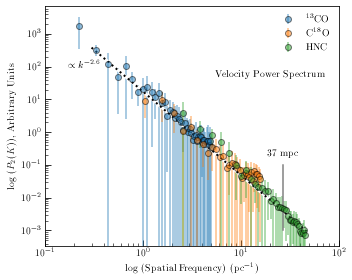

In [206]:
fig, ax = plt.subplots(figsize=(5, 4))

f_13co = soln_hnc_vc.x[2]
f_hnc = soln_hnc_vc.x[3]

label_power_fit = r'$\propto k^{'
label_power_fit = label_power_fit + '{0}'.format(np.round(soln_hnc_vc.x[1], decimals=1)) + '}$'

ax.errorbar(freq_vc_13co, f_13co * P_vc_13co, yerr=f_13co * eP_vc_13co, 
            alpha=0.5, markeredgecolor='k', label=r'$^{13}$CO', fmt="o")
ax.errorbar(freq_vc_c18o, P_vc_c18o, yerr=eP_vc_c18o, 
            alpha=0.5, markeredgecolor='k', label=r'C$^{18}$O', fmt="o")
ax.errorbar(freq_vc_hnc, f_hnc * P_vc_hnc, yerr=f_hnc * eP_vc_hnc, 
            alpha=0.5, markeredgecolor='k', label=r'HNC', fmt="o")

x_sample = np.array([0.3, 50])
ax.plot(x_sample, soln_hnc_vc.x[0] * np.power(x_sample, soln_hnc_vc.x[1]), color='w', lw=3)
ax.plot(x_sample, soln_hnc_vc.x[0] * np.power(x_sample, soln_hnc_vc.x[1]), color='k', lw=2, ls=':')

ax.text(0.25, 1e2, label_power_fit, horizontalalignment='center')

plt.legend(frameon=False)
ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
ax.set_ylabel(r'log ($P_2(K)$), Arbitrary Units')
ax.set_xscale('log')
ax.set_yscale('log')

ax.text(20, 5e1, 'Velocity Power Spectrum', horizontalalignment='center')

ax.plot([1./37e-3, 1./37e-3], [1e-3, 0.1], color='gray')
ax.text(1./37e-3, 0.2, '37 mpc', horizontalalignment='center')

ax.set_xlim(0.1, 100)
plt.tight_layout()
fig.savefig('figs/NGC1333_Velocity_Power_Spectrum_Arb_fit_HNC.pdf')

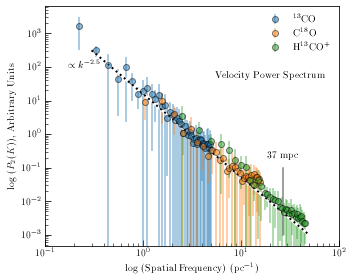

In [207]:
fig, ax = plt.subplots(figsize=(5, 4))

f_13co = soln_h13cop_vc.x[2]
f_h13cop = 0.05 # soln_h13cop_vc.x[3]

label_power_fit = r'$\propto k^{'
label_power_fit = label_power_fit + '{0}'.format(np.round(soln_h13cop_vc.x[1], decimals=1)) + '}$'

ax.errorbar(freq_vc_13co, f_13co * P_vc_13co, yerr=f_13co * eP_vc_13co, 
            alpha=0.5, markeredgecolor='k', label=r'$^{13}$CO', fmt="o")
ax.errorbar(freq_vc_c18o, P_vc_c18o, yerr=eP_vc_c18o, 
            alpha=0.5, markeredgecolor='k', label=r'C$^{18}$O', fmt="o")
ax.errorbar(freq_vc_h13cop, f_h13cop * P_vc_h13cop, yerr=f_h13cop * eP_vc_h13cop, 
            alpha=0.5, markeredgecolor='k', label=r'H$^{13}$CO$^{+}$', fmt="o")

x_sample = np.array([0.3, 50])
ax.plot(x_sample, soln_h13cop_vc.x[0] * np.power(x_sample, soln_h13cop_vc.x[1]), color='w', lw=3)
ax.plot(x_sample, soln_h13cop_vc.x[0] * np.power(x_sample, soln_h13cop_vc.x[1]), color='k', lw=2, ls=':')

ax.text(0.25, 1e2, label_power_fit, horizontalalignment='center')

plt.legend(frameon=False)
ax.set_xlabel(r'log (Spatial Frequency) (pc$^{-1}$)')
ax.set_ylabel(r'log ($P_2(K)$), Arbitrary Units')
ax.set_xscale('log')
ax.set_yscale('log')

ax.text(20, 5e1, 'Velocity Power Spectrum', horizontalalignment='center')

ax.plot([1./37e-3, 1./37e-3], [1e-3, 0.1], color='gray')
ax.text(1./37e-3, 0.2, '37 mpc', horizontalalignment='center')

ax.set_xlim(0.1, 100)
plt.tight_layout()
fig.savefig('figs/NGC1333_Velocity_Power_Spectrum_Arb_fit_H13COp.pdf')